## Install and Load Packages

In [36]:
!pip install category_encoders
!pip install pandas openpyxl
!pip install torch
!pip install klib


In [37]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import category_encoders as ce
import klib
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
import plotly.express as px
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, confusion_matrix, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

warnings.filterwarnings('ignore')

## Load in and Examine Dataset

In [38]:
df = pd.read_csv(r"/Users/myronmoskalyk/Library/CloudStorage/OneDrive-UniversityofToronto/Lectures/Applied Machine Learning/datathon 4/Datathon4/datathon4.csv")
df.head(10)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
5,33181,74489,83,0,67.0,27.56,0,Caucasian,M,190.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
6,82208,49526,83,0,59.0,57.45,0,Caucasian,F,165.1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
7,120995,50129,33,0,70.0,NaN,0,Caucasian,M,165.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sepsis,Cardiovascular
8,80471,10577,118,1,45.0,NaN,0,Caucasian,M,170.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
9,42871,90749,118,0,50.0,25.71,0,NaN,M,175.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular


In [39]:
# Lets look at some strata by comorbidity/condition
print(np.shape(df))
print('There are ' + str(len(df['hospital_id'].unique()))+ ' hospital locations')
print('There are ' + str((df['aids']==1).sum()) + ' patients with aids')
print('There are ' + str((df['cirrhosis']==1).sum()) + ' patients with cirrhosis')
print('There are ' + str((df['diabetes_mellitus']==1).sum()) + ' patients with diabetes mellitus')
print('There are ' + str((df['hepatic_failure']==1).sum()) + ' patients with hepatic failure')
print('There are ' + str((df['immunosuppression']==1).sum()) + ' patients with immunosuppresion')
print('There are ' + str((df['leukemia']==1).sum()) + ' patients with leukemia')
print('There are ' + str((df['lymphoma']==1).sum()) + ' patients with lymphoma')
print('There are ' + str((df['solid_tumor_with_metastasis']==1).sum()) + ' patients with metastasis')

(91713, 186)
There are 147 hospital locations
There are 78 patients with aids
There are 1428 patients with cirrhosis
There are 20492 patients with diabetes mellitus
There are 1182 patients with hepatic failure
There are 2381 patients with immunosuppresion
There are 643 patients with leukemia
There are 376 patients with lymphoma
There are 1878 patients with metastasis


In [40]:
original_columns = set(df.columns)

In [41]:
# Drop columns with duplicate values
df = klib.data_cleaning(df)
print(df.info())

Shape of cleaned data: (91712, 179) - Remaining NAs: 5237705


Dropped rows: 1
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 7
     of which 1 single valued.     Columns: ['readmission_status']
Dropped missing values: 505787
Reduced memory by at least: 70.76 MB (-54.37%)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91712 entries, 0 to 91711
Columns: 179 entries, encounter_id to apache_2_bodysystem
dtypes: category(8), float32(164), int16(2), int32(2), int8(3)
memory usage: 59.4 MB
None


In [42]:
cleaned_columns = set(df.columns)
dropped_columns = original_columns - cleaned_columns
print(dropped_columns)

{'h1_bilirubin_min', 'readmission_status', 'h1_albumin_min', 'h1_albumin_max', 'h1_bilirubin_max', 'h1_lactate_max', 'h1_lactate_min'}


In [43]:
# Drop identifiers
df = df.drop(['encounter_id','patient_id','hospital_id'], axis = 1) 

In [44]:
df = df.drop(['height', 'weight'], axis = 1)

In [45]:
# Drop APACHE scores, clinical and systematic variables, and body systems (we want to compare our model to APACHE scoring ability)
df = df.drop(['apache_4a_hospital_death_prob','apache_4a_icu_death_prob','apache_2_diagnosis', 'apache_3j_diagnosis'], axis = 1) 
df = df.drop(['apache_3j_bodysystem','apache_2_bodysystem'], axis = 1) 
df = df.drop(['albumin_apache','apache_post_operative','arf_apache','bilirubin_apache','bun_apache','creatinine_apache','fio2_apache','gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache','glucose_apache','heart_rate_apache','hematocrit_apache','intubated_apache','map_apache','paco2_apache','paco2_for_ph_apache','pao2_apache','ph_apache','resprate_apache','sodium_apache','temp_apache','urineoutput_apache','ventilated_apache','wbc_apache'], axis = 1)

In [46]:
# Drop all blood-gas measurements (we have a lot of vitals and lab stats already)
df = df.drop(['d1_arterial_pco2_max','d1_arterial_pco2_min','d1_arterial_ph_max','d1_arterial_ph_min','d1_arterial_po2_max','d1_arterial_po2_min','d1_pao2fio2ratio_max','d1_pao2fio2ratio_min','h1_arterial_pco2_max','h1_arterial_pco2_min','h1_arterial_ph_max','h1_arterial_ph_min','h1_arterial_po2_max','h1_arterial_po2_min','h1_pao2fio2ratio_max','h1_pao2fio2ratio_min',], axis = 1) 

In [47]:
# Drop comorbidities and other conditions (we can stratify or try including later if we want to but for now lets assume these get captured by vitals/lab)
df = df.drop(['aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis'], axis = 1) 

In [48]:
print(np.shape(df))

i = 1
for column in df.columns:
    print('Column ' + str(i) + ' is ' + column)
    i = i+1

(91712, 118)
Column 1 is hospital_death
Column 2 is age
Column 3 is bmi
Column 4 is elective_surgery
Column 5 is ethnicity
Column 6 is gender
Column 7 is hospital_admit_source
Column 8 is icu_admit_source
Column 9 is icu_id
Column 10 is icu_stay_type
Column 11 is icu_type
Column 12 is pre_icu_los_days
Column 13 is d1_diasbp_invasive_max
Column 14 is d1_diasbp_invasive_min
Column 15 is d1_diasbp_max
Column 16 is d1_diasbp_min
Column 17 is d1_diasbp_noninvasive_max
Column 18 is d1_diasbp_noninvasive_min
Column 19 is d1_heartrate_max
Column 20 is d1_heartrate_min
Column 21 is d1_mbp_invasive_max
Column 22 is d1_mbp_invasive_min
Column 23 is d1_mbp_max
Column 24 is d1_mbp_min
Column 25 is d1_mbp_noninvasive_max
Column 26 is d1_mbp_noninvasive_min
Column 27 is d1_resprate_max
Column 28 is d1_resprate_min
Column 29 is d1_spo2_max
Column 30 is d1_spo2_min
Column 31 is d1_sysbp_invasive_max
Column 32 is d1_sysbp_invasive_min
Column 33 is d1_sysbp_max
Column 34 is d1_sysbp_min
Column 35 is d1_s

The rationale behind excluding these variables lies in targeting patient-specific data within the first 24 hours in ICU.
This should help in avoiding potential biases from pre-calculated scores or classifications.
The model we generate will predict mortality risk based on immediate, observable clinical factors.


## Check Missing Values

In [49]:
missing_value_counts = df.isnull().sum()
print(missing_value_counts[missing_value_counts > 0])

age                       4227
bmi                       3429
ethnicity                 1395
gender                      25
hospital_admit_source    21408
                         ...  
h1_potassium_min         72101
h1_sodium_max            72616
h1_sodium_min            72616
h1_wbc_max               75952
h1_wbc_min               75952
Length: 112, dtype: int64


In [50]:
labdata = ['d1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_creatinine_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_hco3_max', 'd1_hco3_min', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_inr_max', 'd1_inr_min', 'd1_lactate_max', 'd1_lactate_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_potassium_max', 'd1_potassium_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_wbc_max', 'd1_wbc_min', 'h1_albumin_max', 'h1_albumin_min', 'h1_bilirubin_max', 'h1_bilirubin_min', 'h1_bun_max', 'h1_bun_min', 'h1_calcium_max', 'h1_calcium_min', 'h1_creatinine_max', 'h1_creatinine_min', 'h1_glucose_max', 'h1_glucose_min', 'h1_hco3_max', 'h1_hco3_min', 'h1_hemaglobin_max', 'h1_hemaglobin_min', 'h1_hematocrit_max', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_max', 'h1_lactate_min', 'h1_platelets_max', 'h1_platelets_min', 'h1_potassium_max', 'h1_potassium_min', 'h1_sodium_max', 'h1_sodium_min', 'h1_wbc_max', 'h1_wbc_min']

In [51]:
labdata = set(labdata)
labdata = labdata - dropped_columns
labdata = list(labdata)

We will use 85% as a threshold for data removal. When a column has more than 85% of data missing it will be dropped. 
Since we have 91713 rows, when a column has 13756 rows or less (77957 or more missing), we will remove that column.

In [52]:
# Filter the missing value counts for only labdata columns
labdata_missing_counts = missing_value_counts[labdata]

# Print the missing value counts for labdata
print(labdata_missing_counts[labdata_missing_counts > 0])

# Calculate the percentage of missing values for each column in labdata
labdata_missing_percent = (labdata_missing_counts / len(df)) * 100

# Sort the percentages in descending order
labdata_missing_percent_sorted = labdata_missing_percent.sort_values(ascending=False)

# Print the sorted missing value percentages for labdata
print("Percentage of Missing Values in Lab Data Columns (from most to least):")
print(labdata_missing_percent_sorted[labdata_missing_percent_sorted > 0])

# Calculate and print the total percentage of missing values across all labdata columns
total_labdata_missing_percent = labdata_missing_counts.sum() / (len(df) * len(labdata)) * 100
print(f"Total percentage of missing values in labdata columns: {total_labdata_missing_percent:.2f}%")


d1_creatinine_min    10168
d1_bun_min           10513
d1_wbc_min           13173
h1_inr_min           57940
d1_lactate_min       68395
h1_sodium_max        72616
d1_albumin_max       49095
d1_bilirubin_min     53672
d1_glucose_min        5806
d1_potassium_min      9584
d1_inr_max           57940
h1_hemaglobin_max    73122
d1_hemaglobin_max    12146
d1_inr_min           57940
h1_platelets_max     75672
d1_sodium_max        10194
h1_calcium_min       75862
h1_hco3_min          76093
d1_lactate_max       68395
h1_inr_max           57940
d1_hco3_max          15070
h1_hematocrit_min    73419
d1_calcium_max       13068
h1_creatinine_max    74956
h1_potassium_max     72101
h1_wbc_min           75952
h1_bun_max           75090
d1_bun_max           10513
d1_bilirubin_max     53672
d1_albumin_min       49095
d1_potassium_max      9584
h1_sodium_min        72616
h1_hco3_max          76093
h1_glucose_max       52613
h1_creatinine_min    74956
d1_sodium_min        10194
d1_hematocrit_max    11653
h

In [53]:
# These columns have missingness split at 53%. There was a distinct break in the data. These are all data taken within the first day. 
# We will drop the data above 53% since the split most likely implies some change in severity
# In any case, this data may not be present in many patients (with some unidentified pattern), therefore we will not use it since real data may not contain it either.
low_missingness_labdata = ['d1_hco3_max', 'd1_hco3_min', 'd1_platelets_max', 'd1_platelets_min', 'd1_wbc_min', 'd1_wbc_max', 'd1_calcium_min', 'd1_calcium_max', 'd1_hemaglobin_max', 'd1_hemaglobin_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_bun_max', 'd1_bun_min', 'd1_sodium_max', 'd1_sodium_min', 'd1_creatinine_min', 'd1_creatinine_max', 'd1_potassium_max', 'd1_potassium_min', 'd1_glucose_max', 'd1_glucose_min']
high_missingness_labdata = ['h1_hco3_min', 'h1_hco3_max', 'h1_wbc_min', 'h1_wbc_max','h1_calcium_max', 'h1_calcium_min', 'h1_platelets_min', 'h1_platelets_max','h1_bun_min', 'h1_bun_max', 'h1_creatinine_max', 'h1_creatinine_min','h1_hematocrit_max', 'h1_hematocrit_min', 'h1_hemaglobin_min', 'h1_hemaglobin_max','h1_sodium_max', 'h1_sodium_min', 'h1_potassium_min', 'h1_potassium_max','d1_lactate_min', 'd1_lactate_max', 'd1_inr_min', 'd1_inr_max','h1_inr_max', 'h1_inr_min', 'd1_bilirubin_max', 'd1_bilirubin_min','h1_glucose_max', 'h1_glucose_min', 'd1_albumin_min', 'd1_albumin_max']


In [54]:
dropcol_85 = (missing_value_counts[missing_value_counts > 77957])
dropcol_85

Series([], dtype: int64)

In [55]:
df = df.drop(high_missingness_labdata, axis = 1)

In [56]:
df['ethnicity'].unique()
df['ethnicity'] = df['ethnicity'].fillna('Other/Unknown')
print(df['ethnicity'].unique())

['Caucasian', 'Other/Unknown', 'Hispanic', 'African American', 'Asian', 'Native American']
Categories (6, object): ['African American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other/Unknown']


Note:

We will use MICE for all imputation for consistency. 

In [57]:
np.shape(df)

(91712, 86)

In [58]:
categorical_columns = df.select_dtypes(include=['category']).columns
print(categorical_columns)
np.shape(categorical_columns)

Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type'],
      dtype='object')


(6,)

In [59]:
print("There are " + str(len(df['ethnicity'].unique())) + " categories")
print("There are " + str(len(df['gender'].unique())) + " categories (including NAN)")
print("There are " + str(len(df['hospital_admit_source'].unique())) + " categories (including NAN)")
print("There are " + str(len(df['icu_admit_source'].unique())) + " categories (including NAN)")
print("There are " + str(len(df['icu_stay_type'].unique())) + " categories (including NAN)")
print("There are " + str(len(df['icu_type'].unique())) + " categories (including NAN)")

There are 6 categories
There are 3 categories (including NAN)
There are 16 categories (including NAN)
There are 6 categories (including NAN)
There are 3 categories (including NAN)
There are 8 categories (including NAN)


In [60]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

We will encode using one-hot for all cat columns except hospital admit source which will use label encoding

# Feature Selection

In [61]:
def fit_transform(input_df):
    # Initialize transformers and imputers
    imputer = IterativeImputer(max_iter=10, random_state=0)
    scaler = StandardScaler()
    label_encoder = LabelEncoder()

    # Create a copy of the input DataFrame to avoid modifying the original data
    df = input_df.copy()

    # One-hot encoding for specified columns except 'hospital_admit_source'
    categorical_columns_hot = ['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type','icu_type']  # Replace with your actual columns
    for column in categorical_columns_hot:
        if column in df.columns:
            encoded = pd.get_dummies(df[column], prefix=column, drop_first=True)
            df = pd.concat([df, encoded], axis=1)
            df.drop(column, axis=1, inplace=True)

    # Label Encoding for 'hospital_admit_source'
    if 'hospital_admit_source' in df.columns:
        df['hospital_admit_source'] = label_encoder.fit_transform(df['hospital_admit_source'].astype(str))

    # Perform imputation and standardization on the feature matrix
    X = imputer.fit_transform(df.drop('hospital_death', axis=1)) 
    X = scaler.fit_transform(X)

    # Extract the target variable 'hospital_death'
    Y = df['hospital_death'].to_numpy() 

    # Return the preprocessed feature matrix, target variable, and transformers/imputers
    return X, Y, imputer, scaler, label_encoder

In [62]:
def transform(input_df, imputer, scaler, label_encoder):
    # Create a copy of the input DataFrame to avoid modifying the original data
    df = input_df.copy()

    # One-hot encoding for specified columns except 'hospital_admit_source'
    categorical_columns_hot = ['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type','icu_type']  # Replace with your actual columns
    for column in categorical_columns_hot:
        if column in df.columns:
            encoded = pd.get_dummies(df[column], prefix=column, drop_first=True)
            df = pd.concat([df, encoded], axis=1)
            df.drop(column, axis=1, inplace=True)

    # Label Encoding for 'hospital_admit_source'
    if 'hospital_admit_source' in df.columns:
        df['hospital_admit_source'] = label_encoder.transform(df['hospital_admit_source'].astype(str))

    # Perform imputation and standardization on the feature matrix
    X = imputer.transform(df.drop('hospital_death', axis=1))  # Ensure correct target column name
    X = scaler.transform(X)

    # Return the transformed feature matrix
    return X

In [63]:
# Import necessary libraries for feature selection and logistic regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Split the data into training and testing sets
train = df.sample(frac=0.7, random_state=10)
test = df.drop(train.index)

# Preprocess and transform the training and test sets
X_train, Y_train, imputer, scaler, label_encoder = fit_transform(train)

X_test = transform(test, imputer, scaler, label_encoder)
Y_test = test['hospital_death'].to_numpy()

# Initialize a Logistic Regression model
model = LogisticRegression()

# Define a StratifiedKFold cross-validation
cv = StratifiedKFold(3)

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='roc_auc',  # Specify the scoring metric (ROC AUC in this case)
    min_features_to_select=1,
)
rfecv.fit(X_train, Y_train)

# Print the optimal number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 87


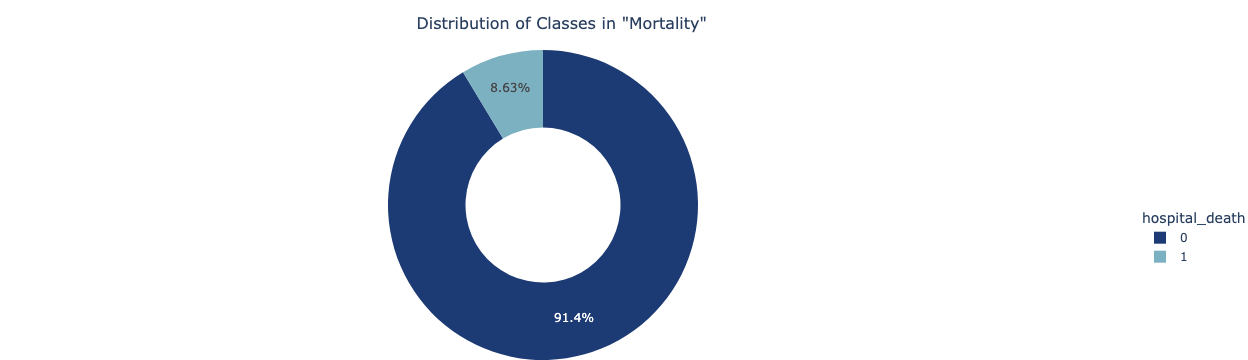

In [64]:
counts = df['hospital_death'].value_counts()

# Define your color sequence
colors = ['#1c3a73', '#7cb1c2']

fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # size of the hole, 0.5 means 50%
    title='Distribution of Classes in "hospital_death"',
    color_discrete_sequence=colors  # apply your colors here
)

# Update layout for better appearance
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),  # Adjust top margin to make room for title
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='hospital_death'
    ),
    title=dict(
        text='Distribution of Classes in "Mortality"',
        x=0.45,  # Centering the title
        xanchor='center',
        y=0.95,  # Adjusting y position to place title above chart
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

fig.show()

In [65]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC

smote = SMOTE(random_state=42)

X_train_balanced, Y_train_balanced = smote.fit_resample(X_train, Y_train)

In [66]:
from collections import Counter
# Before SMOTE
print("Class distribution before SMOTE:", Counter(Y_train))
# After SMOTE
print("Class distribution after SMOTE:", Counter(Y_train_balanced))



Class distribution before SMOTE: Counter({0: 58648, 1: 5550})
Class distribution after SMOTE: Counter({0: 58648, 1: 58648})


# Neural Net


In [67]:
# importing PyTorch library as 't' for convenience
import torch as t

# importing other necessary libraries
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# importing PyTorch modules for building neural networks
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

In [68]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, and accuracy
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc, acc

# Define a function to print the computed scores
def print_scores(conf_matrix, class_report, auc, acc):
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

Fold 1, Epoch 1, Average Loss: 0.5713
Fold 1, Epoch 2, Average Loss: 0.5658
Fold 1, Epoch 3, Average Loss: 0.5641
Fold 1, Epoch 4, Average Loss: 0.5647
Fold 1, Epoch 5, Average Loss: 0.5639
Fold 1, Epoch 6, Average Loss: 0.5639
Fold 1, Epoch 7, Average Loss: 0.5634
Fold 1, Epoch 8, Average Loss: 0.5626
Fold 1, Epoch 9, Average Loss: 0.5646
Fold 1, Epoch 10, Average Loss: 0.5631
Fold 1, Epoch 11, Average Loss: 0.5634
Fold 1, Epoch 12, Average Loss: 0.5627
Fold 1, Epoch 13, Average Loss: 0.5632
Fold 1, Epoch 14, Average Loss: 0.5624
Fold 1, Epoch 15, Average Loss: 0.5643
Fold 1, Epoch 16, Average Loss: 0.5626
Fold 1, Epoch 17, Average Loss: 0.5629
Fold 1, Epoch 18, Average Loss: 0.5634
Fold 1, Epoch 19, Average Loss: 0.5637
Fold 1, Epoch 20, Average Loss: 0.5621
Fold 1, Epoch 21, Average Loss: 0.5633
Fold 1, Epoch 22, Average Loss: 0.5623
Fold 1, Epoch 23, Average Loss: 0.5619
Fold 1, Epoch 24, Average Loss: 0.5615
Fold 1, Epoch 25, Average Loss: 0.5646
Fold 1, Epoch 26, Average Loss: 0.

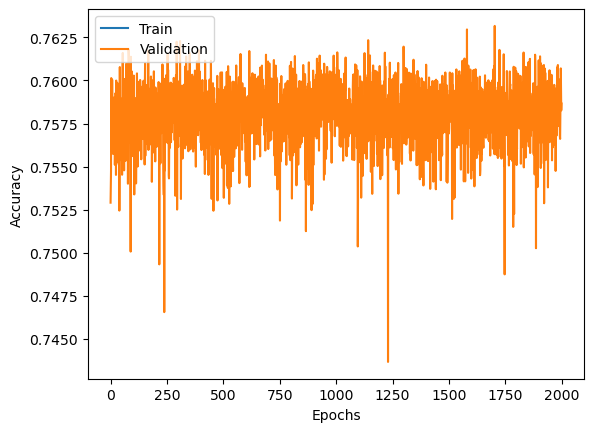

AUC :  0.7584241657186119
Accuracy :  0.7580374906220161
Confusion Matrix:
[[86646156 26112625]
 [30649844 91183375]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75 112758781
           1       0.78      0.75      0.76 121833219

    accuracy                           0.76 234592000
   macro avg       0.76      0.76      0.76 234592000
weighted avg       0.76      0.76      0.76 234592000



In [69]:
# NEWEST

import torch as t
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Define hyperparameters
number_of_input_features = X_train_balanced.shape[1]
number_of_hidden_units = 60
epochs = 2000
learning_rate = 0.01
batch_size = 32
landa = 0.01  # Regularization term (lambda)

# K-Fold Cross-Validation setup
k = 5  # Number of folds
kfold = KFold(n_splits=k, shuffle=True)

fold_train_losses = []
fold_validation_losses = []

# Lists to store average accuracy across folds for each epoch
avg_train_accuracy_list = [[] for _ in range(epochs)]
avg_validation_accuracy_list = [[] for _ in range(epochs)]

all_folds_predictions = []
all_folds_actuals = []

for fold, (train_indexes, validation_indexes) in enumerate(kfold.split(X_train_balanced, Y_train_balanced)):
    X_train_fold = X_train_balanced[train_indexes]
    Y_train_fold = Y_train_balanced[train_indexes]
    X_validation_fold = X_train_balanced[validation_indexes]
    Y_validation_fold = Y_train_balanced[validation_indexes]

    # Convert to tensors
    X_train_tensor = t.tensor(X_train_fold).type(t.float32)
    Y_train_tensor = t.tensor(Y_train_fold).type(t.float32)
    X_validation_tensor = t.tensor(X_validation_fold).type(t.float32)
    Y_validation_tensor = t.tensor(Y_validation_fold).type(t.float32)

    # DataLoader for the training data
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define the neural network model with regularization
    model = nn.Sequential(
        nn.Linear(number_of_input_features, number_of_hidden_units),
        nn.Tanh(),
        nn.Linear(number_of_hidden_units, 1),
        nn.Sigmoid()
    )

    # Define the optimizer
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Define the loss function with Binary Cross-Entropy Loss
    loss_fn = nn.BCELoss()

    # Train the model for this fold
    for epoch in range(epochs):
        if epoch % 500 == 0:
            learning_rate *= 0.9

        epoch_loss = 0.0
        for batch_idx, (X, Y) in enumerate(train_data_loader):
            # Forward pass: Compute predictions
            probs = model(X)

            # Adding regularization term for all parameters in the model
            l2_term = sum([(w ** 2).sum() for w in model.parameters() if w.requires_grad and w.ndim > 1])

            # New loss is the old loss + regularization term
            loss = loss_fn(probs.view(-1), Y) + landa * l2_term

            # Backward pass: Compute gradient and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Print the average loss for this epoch
        epoch_loss /= len(train_data_loader)
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Average Loss: {epoch_loss:.4f}')

        # Evaluate the model on the validation data
        with t.no_grad():
            validation_probs = model(X_validation_tensor)
            validation_prediction = (validation_probs >= 0.5).type(t.LongTensor).view(-1)
            validation_accuracy = (validation_prediction == Y_validation_tensor).type(t.float32).mean().item()
            avg_validation_accuracy_list[epoch].append(validation_accuracy)
            
            all_folds_predictions.extend(validation_prediction.numpy())
            all_folds_actuals.extend(Y_validation_tensor.numpy())

# Calculate average accuracy per epoch across all folds
mean_train_accuracy_per_epoch = [np.mean(accuracies) for accuracies in avg_train_accuracy_list]
mean_validation_accuracy_per_epoch = [np.mean(accuracies) for accuracies in avg_validation_accuracy_list]

# Plotting
plt.plot([i for i in range(epochs)], mean_train_accuracy_per_epoch, label="Train")
plt.plot([i for i in range(epochs)], mean_validation_accuracy_per_epoch, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Define the functions to calculate scores (assuming they are already defined)
conf_matrix, class_report, auc, acc = get_scores(all_folds_predictions, all_folds_actuals)
print_scores(conf_matrix, class_report, auc, acc)


In [71]:
X_train_balanced.shape

(117296, 99)

In [73]:
X_train_balanced

array([[ 1.47038722, -1.3102262 , -0.47580785, ...,  0.90049648,
        -0.30160868, -0.24445382],
       [ 0.02157328, -0.19320851, -0.47580785, ..., -1.11049851,
         3.31555443, -0.24445382],
       [-0.40099746, -0.51531633, -0.47580785, ...,  0.90049648,
        -0.30160868, -0.24445382],
       ...,
       [-0.03146027,  0.45682083, -0.47580785, ...,  0.90049648,
        -0.30160868, -0.24445382],
       [ 0.93466554, -0.11969028, -0.47580785, ...,  0.90049648,
        -0.30160868, -0.24445382],
       [ 1.01097328, -0.87837475, -0.47580785, ...,  0.90049648,
        -0.30160868, -0.24445382]])

In [75]:
X_train.shape

(64198, 99)